In [ ]:
%env ROOTPATH=/content/drive/MyDrive/

Download dataset

In [ ]:
!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip $rootPath

Install

In [ ]:
!unzip ${ROOTPATH}/FullIJCNN2013.zip
!mkdir ${ROOTPATH}/dataset/train ${ROOTPATH}/dataset/test
!mv ${ROOTPATH}/dataset/00 ${ROOTPATH}/dataset/train/0
!mv ${ROOTPATH}/dataset/0* ${ROOTPATH}/dataset/test/
!mv ${ROOTPATH}/dataset/0* ${ROOTPATH}/dataset/1* ${ROOTPATH}/dataset/2* ${ROOTPATH}/dataset/3* ${ROOTPATH}/dataset/4* ${ROOTPATH}/dataset/train

Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers.pooling import MaxPooling2D
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D
import pickle

Variable

In [15]:
rootDir = Path("/content/drive/MyDrive/Traffic-Sign/")
dataDir = rootDir/"dataset/"
trainDir = dataDir/"train/"
testDir = dataDir/"test/"

testRatio = 0.2
validationRatio = 0.2
imageDimensions = (64, 64)

In [16]:
numberOfClasses = len(os.listdir(trainDir))
print("Class number: {}".format(numberOfClasses))

Class number: 43


Load Training Data

In [17]:
images = []
classes = []

for folder in trainDir.glob("*"):
  trainImage = (trainDir/folder.name).glob("*.ppm")
  for img in trainImage:
    images.append(trainDir/folder.name/img)
    classes.append(int(folder.name))

images = np.array(images)
classes = np.array(classes)

Spliting Data

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(images, classes, test_size=testRatio)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validationRatio)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_validation = np.array(X_validation)

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
Y_validation = np.array(Y_validation)

Number of the Samples

In [19]:
numberOfSamples = []
for i in range(0, numberOfClasses):
  numberOfSamples.append(len(np.where(Y_train==i)[0]))
print(numberOfSamples)

[3, 51, 50, 16, 34, 31, 14, 29, 34, 27, 57, 22, 53, 49, 19, 9, 5, 21, 23, 1, 8, 5, 10, 15, 3, 19, 12, 2, 9, 4, 13, 1, 6, 11, 8, 12, 8, 1, 59, 3, 7, 4, 8]


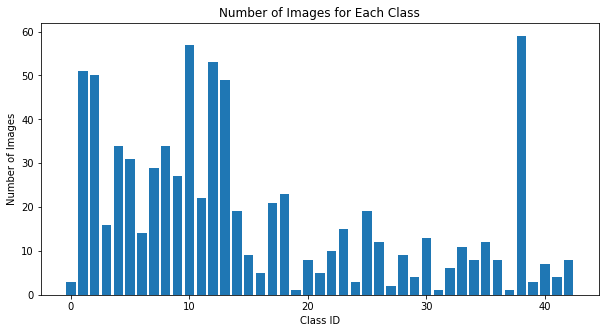

In [20]:
plt.figure(figsize=(10, 5))
plt.bar(range(0, numberOfClasses), numberOfSamples)
plt.title("Number of Images for Each Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

Preproccessing

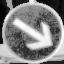

In [21]:
def preProccessing(img):
  img = cv2.imread(str(img))
  img = cv2.resize(img, (imageDimensions[0], imageDimensions[1]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  # img = img/255.
  return img

img = preProccessing(X_train[30])
cv2_imshow(img)

In [22]:
X_train = np.array(list(map(preProccessing, X_train)))
X_test = np.array(list(map(preProccessing, X_test)))
X_validation = np.array(list(map(preProccessing, X_validation)))

In [23]:
# img = X_train[30]
# cv2.resize(img, (300,300))
# cv2_imshow(img)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
print(X_train.shape)

(776, 64, 64, 1)


In [24]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
dataGen.fit(X_train)
Y_train = to_categorical(Y_train, numberOfClasses)
Y_test = to_categorical(Y_test, numberOfClasses)
Y_validation = to_categorical(Y_validation, numberOfClasses)

In [68]:
import tensorflow
def myModel():
  numberOfFilters = 32
  sizeOfFilter1 = (5, 5)
  sizeOfFilter2 = (3, 3)
  sizeOfPool = (2, 2)
  numberOfNode = 1000

  model = keras.Sequential()
  model.add((Conv2D(numberOfFilters, sizeOfFilter1, input_shape=(imageDimensions[0],
                                                                       imageDimensions[1],
                                                                       1), activation="relu")))
  model.add((Conv2D(numberOfFilters, sizeOfFilter1, activation="relu")))
  model.add(MaxPooling2D(pool_size=sizeOfPool))
  model.add((Conv2D(numberOfFilters*2, sizeOfFilter2, activation="relu")))
  model.add((Conv2D(numberOfFilters*2, sizeOfFilter2, activation="relu")))
  model.add(MaxPooling2D(pool_size=sizeOfPool))
  model.add(keras.layers.Dropout(0.25))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(numberOfNode, activation="relu"))
  model.add(keras.layers.Dropout(0.25))
  model.add(keras.layers.Dense(numberOfClasses, activation="softmax"))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = myModel()
# print(model.summary())

In [69]:
batchSizeValue = 32
epochsValue = 15
stepsPerEpoch = len(X_train)//batchSizeValue

history = model.fit(dataGen.flow(X_train, Y_train,
                                 batch_size=batchSizeValue),
                    steps_per_epoch=stepsPerEpoch,
                    epochs=epochsValue,
                    validation_data=(X_validation, Y_validation),
                    shuffle=1)



Epoch 1/15
24/24 [==============================] - 24s 959ms/step - loss: 11.4820 - accuracy: 0.0833 - val_loss: 3.1433 - val_accuracy: 0.2423
Epoch 2/15
24/24 [==============================] - 22s 901ms/step - loss: 3.1527 - accuracy: 0.2083 - val_loss: 2.3278 - val_accuracy: 0.4124
Epoch 3/15
24/24 [==============================] - 22s 904ms/step - loss: 2.5681 - accuracy: 0.3414 - val_loss: 1.8114 - val_accuracy: 0.4330
Epoch 4/15
24/24 [==============================] - 23s 923ms/step - loss: 2.1181 - accuracy: 0.4194 - val_loss: 1.3250 - val_accuracy: 0.6443
Epoch 5/15
24/24 [==============================] - 23s 951ms/step - loss: 1.8216 - accuracy: 0.4852 - val_loss: 1.2830 - val_accuracy: 0.5773
Epoch 6/15
24/24 [==============================] - 22s 935ms/step - loss: 1.5708 - accuracy: 0.5645 - val_loss: 0.8213 - val_accuracy: 0.7165
Epoch 7/15
24/24 [==============================] - 22s 904ms/step - loss: 1.2475 - accuracy: 0.6116 - val_loss: 0.6621 - val_accuracy: 0.814

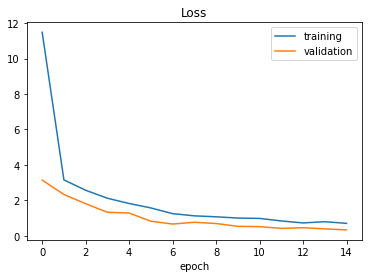

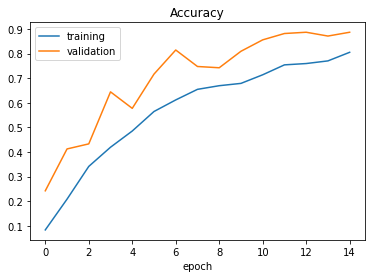

Test Score: 0.32701462507247925
Test Accuracy: 0.9176954627037048
INFO:tensorflow:Assets written to: ram://71ae002d-46ef-4cc9-ba64-a9f0d6e6bc7f/assets


In [70]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: {}".format(score[0]))
print("Test Accuracy: {}".format(score[1]))

pickleOut = open(rootDir/"modelTrained.p", "wb")
pickle.dump(model, pickleOut)
pickleOut.close()

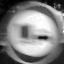

[10] 0.99902034


In [75]:
pickleIn = open(rootDir/"modelTrained.p", "rb")
model = pickle.load(pickleIn)

img = preProccessing(str(trainDir/"10"/"00002.ppm"))
cv2_imshow(img)
img = img.reshape(1,64,64,1)

prediction = model.predict(img)
probVal = np.amax(prediction)
classIndex = np.argmax(prediction, axis=1)
print(classIndex, probVal)